# Back to Regression | proximity-quadrotor-learning

https://github.com/idsia-robotics/proximity-quadrotor-learning

## Settings

In [1]:
################################
### KNOWN IMPORTS
######

import math
import os
import time
import errno
import random
import sys
import gc
from datetime import datetime

# %tensorflow_version 1.x
import tensorflow as tf

# when importing keras, please notice:
#   https://stackoverflow.com/a/57298275/10866825
#   https://www.pyimagesearch.com/2019/10/21/keras-vs-tf-keras-whats-the-difference-in-tensorflow-2-0/

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# !pip install resnet
# import resnet as kr

import pickle
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.metrics

import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

# -- for GradCAM
!pip install tf-keras-vis
from tf_keras_vis.utils import normalize
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm


################################
### PATHS
######

# this file goes into the 'PROJECT_ROOT/src/' folder to work properly with the following paths

try:
  import google.colab
  IN_COLAB = True
  from google.colab import drive
  from google.colab.patches import cv2_imshow
  drive.mount('/content/drive')
  %cd '/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/'
except:
  IN_COLAB = False
  from cv2 import imshow as cv2_imshow


this_folder = os.path.realpath('.') # see https://stackoverflow.com/a/32711758/10866825 for details
lib_folder = os.path.join(this_folder, './lib/')
original_models_folder = os.path.join(this_folder, './../dev-models/_originals/') # Dario's original trained models (https://drive.switch.ch/index.php/s/Idsyf8WIwQpvRMF)
original_datasets_folder = os.path.join(this_folder, './../dev-datasets/_originals/') # Dario's original dataset (https://drive.switch.ch/index.php/s/8clDQNH645ZjWDD)
backgrounds_folder = os.path.join(this_folder, './../dev-datasets/_backgrounds/')
new_models_folder = os.path.join(this_folder, './../dev-models/')
new_datasets_folder = os.path.join(this_folder, './../dev-datasets/')
visualization_folder = os.path.join(this_folder, './../dev-visualization/')

dario_model_path = original_models_folder + 'v1_model_train_size_50000_rep_1.h5'
dario_train_path = original_datasets_folder + 'dario/v1_train.pickle'
dario_test_path = original_datasets_folder + 'dario/v1_test.pickle'



################################
### CUSTOM IMPORTS
######

sys.path.append(lib_folder)
import general_utils
import keras_utils

import importlib
importlib.reload(general_utils)
importlib.reload(keras_utils)

You should consider upgrading via the 'c:\users\96mar\appdata\local\programs\python\python38\python3.exe -m pip install --upgrade pip' command.


<module 'keras_utils' from 'C:\\Users\\96mar\\Google Drive\\_ USI\\_ THESIS\\_ Source code\\cnn-drone-befree\\src\\./lib\\keras_utils.py'>

## Create dataset for generator

In [ ]:
## Load MaskRCNN inference

bp = visualization_folder + 'maskRCNN/'
pps =  [
  '20201017_180347 detections orig_train start0 total24215/maskrcnn final - detections orig start0 total24000.npy',
  '20201016_183639 detections orig_train start24000 total31863/maskrcnn final A - detections orig start24000 total15500.npy',
  '20201016_183639 detections orig_train start24000 total31863/maskrcnn final B - detections orig start24000 total15500.npy',
  '20201017_200003 detections orig_train start55000 total8726/maskrcnn final - detections orig start55000 total8720.npy'
]
dataset_name = 'orig_train'

print('loading...')
parts = [np.load(bp + pp, allow_pickle=True) for pp in pps]
print('loaded')

dataset = np.hstack(tuple(parts[:]))
print('dataset shape', np.shape(dataset))
print(dataset[np.random.randint(len(dataset))].keys())

loading...
loaded
dataset shape (63720,)
dict_keys(['image', 'centr', 'bbox', 'mask', 'gt'])


In [ ]:
## Export frames one by one

dataset_size = len(dataset)
dataset_folder = os.path.join(new_datasets_folder, 'maskrcnn_batch', '{} {}/'.format(dataset_name, dataset_size))
general_utils.create_folder_if_not_exist(dataset_folder)

print('Exporting in {}\n'.format(dataset_folder))
frames_filelist = []

start_id = 0

for id, frame in enumerate(dataset[start_id:]):
  frame_name = '{} {} - frame {:06}'.format(dataset_name, dataset_size, start_id + id)
  frame_path = os.path.join(dataset_folder, frame_name + '.pickle')
  frames_filelist.append(frame_path)

  with open(frame_path, 'wb') as fp:
    frame['id'] = start_id + id
    pickle.dump(frame, fp)

  if id % 5000 == 0:
    print('Progress {}/{}'.format(start_id + id, dataset_size))
    gc.collect()

print('\nExport finished.')

path_filelist = os.path.join(dataset_folder, '../{} {} list.pickle'.format(dataset_name, dataset_size))
with open(path_filelist, 'wb') as fp:
  pickle.dump(frames_filelist, fp)

Exporting in /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-datasets/maskrcnn_batch/orig_train 63720/

Progress 0/63720
Progress 5000/63720
Progress 10000/63720
Progress 15000/63720
Progress 20000/63720
Progress 25000/63720
Progress 30000/63720
Progress 35000/63720
Progress 40000/63720
Progress 45000/63720
Progress 50000/63720
Progress 55000/63720
Progress 60000/63720

Export finished.


In [ ]:
%%time

## Check reading performance

path_filelist = os.path.join(new_datasets_folder + 'maskrcnn_batch/orig_train 63720 list.pickle')
with open(path_filelist, 'rb') as fp:
  frames_filelist = pickle.load(fp)

imgs = []
masks = []
gts = []

for fn in frames_filelist:
  with open(os.path.join(new_datasets_folder + 'maskrcnn_batch', fn), 'rb') as fp:
    sample = pickle.load(fp)
    imgs.append(sample['image'])
    masks.append(sample['mask'])
    gts.append(sample['gt'])

CPU times: user 11.1 s, sys: 13.6 s, total: 24.8 s
Wall time: 2min 11s


In [ ]:
### Zip and download

# %cd /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/dev-datasets/maskrcnn_batch
# !zip -r orig_train_63720.zip orig_train\ 63720

# from google.colab import files
# files.download('/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/dev-datasets/maskrcnn_batch/orig_train_63720.zip')

## Training

### Utils

In [2]:
def network_create(original_model_path, input_size, regression, classification, retrain_from_layer = None, view_summary = True, view_plot = False):

  if not regression and not classification:
    raise ValueError("At least one between parameter `regression` and `classification` must be True.")

  # --- Network architecture

  # input
  input_img = Input(shape=(input_size[0], input_size[1], input_size[2]), name = 'input_1')

  # start resnet
  conv_1 = Conv2D(64, kernel_size=(7,7), strides=(2,2), padding='same', name = 'conv2d_1')(input_img)
  batch_1 = BatchNormalization(name = 'batch_normalization_1')(conv_1)
  activ_1 = Activation('relu', name = 'activation_1')(batch_1)
  pool_1 = MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='same', name = 'max_pooling2d_1')(activ_1)

  # block 1
  conv_2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', name = 'conv2d_2')(pool_1)
  batch_2 = BatchNormalization(name = 'batch_normalization_2')(conv_2)
  activ_2 = Activation('relu', name = 'activation_2')(batch_2)
  conv_3 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', name = 'conv2d_3')(activ_2)
  add_1 = Add(name = 'add_1')([conv_3, pool_1])

  # block 2
  batch_3 = BatchNormalization(name = 'batch_normalization_3')(add_1)
  activ_3 = Activation('relu', name = 'activation_3')(batch_3)
  conv_4 = Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same', name = 'conv2d_4')(activ_3)
  batch_4 = BatchNormalization(name = 'batch_normalization_4')(conv_4)
  activ_4 = Activation('relu', name = 'activation_4')(batch_4)
  conv_5 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', name = 'conv2d_5')(activ_4)
  conv_6 = Conv2D(128, kernel_size=(1,1), strides=(2,2), padding='valid', name = 'conv2d_6')(add_1)
  add_2 = Add(name = 'add_2')([conv_5, conv_6])

  # block 3
  batch_5 = BatchNormalization(name = 'batch_normalization_5')(add_2)
  activ_5 = Activation('relu', name = 'activation_5')(batch_5)
  conv_7 = Conv2D(256, kernel_size=(3,3), strides=(2,2), padding='same', name = 'conv2d_7')(activ_5)
  batch_6 = BatchNormalization(name = 'batch_normalization_6')(conv_7)
  activ_6 = Activation('relu', name = 'activation_6')(batch_6)
  conv_8 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', name = 'conv2d_8')(activ_6)
  conv_9 = Conv2D(256, kernel_size=(1,1), strides=(2,2), padding='valid', name = 'conv2d_9')(add_2)
  add_3 = Add(name = 'add_3')([conv_8, conv_9])

  # end resnet
  batch_7 = BatchNormalization(name = 'batch_normalization_7')(add_3)
  activ_7 = Activation('relu', name = 'activation_7')(batch_7)
  pool_2 = AveragePooling2D(pool_size = (4, 7), strides = (1, 1), padding = 'valid', name = 'average_pooling2d_1')(activ_7)

  # dense
  flatten_1 = Flatten(name = 'flatten_1')(pool_2)
  dense_1 = (Dense(256, activation='relu', name="1_dense"))(flatten_1)
  dense_2 = (Dense(128, activation='relu', name="2_dense"))(dense_1)

  # targets
  y_0 = (Dense(1, activation='linear', name=general_utils.variables_names[0]))(dense_2)
  y_1 = (Dense(1, activation='linear', name=general_utils.variables_names[1]))(dense_2)
  y_2 = (Dense(1, activation='linear', name=general_utils.variables_names[2]))(dense_2)
  y_3 = (Dense(1, activation='linear', name=general_utils.variables_names[3]))(dense_2)
  y_4 = (Dense(3, activation='softmax', name=general_utils.variables_names[4]))(dense_2)
  y_5 = (Dense(3, activation='softmax', name=general_utils.variables_names[5]))(dense_2)
  y_6 = (Dense(3, activation='softmax', name=general_utils.variables_names[6]))(dense_2)
  y_7 = (Dense(3, activation='softmax', name=general_utils.variables_names[7]))(dense_2)

  outputs = []
  if regression:
    outputs.extend([y_0, y_1, y_2, y_3])
  if classification:
    outputs.extend([y_4, y_5, y_6, y_7])

  # model
  flat_model = Model(inputs = input_img, outputs = outputs) # MODEL

  # --- Restore weights from Dario's model 

  old_model = tf.keras.models.load_model(original_model_path)

  for layer in old_model.layers[2:]: # starts at 2 for skipping inputs and nested model
    try:
      flat_model.get_layer(layer.name).set_weights(layer.get_weights())
    except ValueError: # get_layer raises ValueError is a layer does not exist
      # for each variable, the respective model only contains the associated variable (so the other outputs will be missing)
      print(layer.name, 'layer not found, skipping')
      continue 

  for layer in old_model.get_layer('model_1').layers: # nested model weights
    flat_model.get_layer(layer.name).set_weights(layer.get_weights())

  # --- Set trainable layers

  if retrain_from_layer is not None:
    non_trainable_until = retrain_from_layer # non-trainable until specified layer
  elif classification:
    non_trainable_until = -4 # classification layers always have to be trained
  else: # regression
    non_trainable_until = len(flat_model.layers) # nothing will be trainable

  for layer in flat_model.layers[:non_trainable_until]:
    layer.trainable =  False

  # --- Result 

  if view_plot: 
    plot_model(flat_model, show_shapes = True, expand_nested = True)
  if view_summary:
    flat_model.summary()
    print('Please note that the network is non-trainable until the {} layer.'.format(non_trainable_until))

  return flat_model



def network_train(model, data_x, data_y, regression, classification, 
                  batch_size = 64, epochs = 30, verbose = 2,
                  validation_split = 0.3, validation_shuffle = True, 
                  use_lr_reducer = True, use_early_stop = False):

  # --- Model settings

  loss = []
  metrics = []

  if regression:
    loss.extend(['mean_absolute_error'] * 4)
    metrics.append('mse')
  if classification:
    loss.extend(['categorical_crossentropy'] * 4)
    metrics.append('accuracy')

  model.compile(loss=loss,
                metrics=metrics,
                optimizer='adam')

  callbacks = []

  if use_lr_reducer:
    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=1, patience=4, min_lr=0.1e-6)
    callbacks.append(lr_reducer)

  if use_early_stop:
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4, verbose=1)
    callbacks.append(early_stop)

  # --- Train/Validation split
  
  n_val = int(len(data_x) * validation_split)
  ix_val, ix_tr = np.split(np.random.permutation(len(data_x)), [n_val])
  
  x_valid = data_x[ix_val, :]
  x_train = data_x[ix_tr, :]
  y_valid = [var[ix_val] for var in data_y]
  y_train = [var[ix_tr] for var in data_y]

  # --- Training

  history = model.fit(
      x = x_train,
      y = y_train,
      batch_size = batch_size,
      epochs = epochs,
      validation_data = (x_valid, y_valid),
      # validation_split = validation_split,
      callbacks = callbacks,
      shuffle = True,
      verbose = verbose
  )

  return model, history



def network_stats(history, regression, classification):
  var_str = 'all_class'

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

  # - Loss

  ax1.plot(history.history['loss'], 'k--', label='Train Loss')
  ax1.plot(history.history['val_loss'], 'k', label='Valid Loss')
  ax1.legend(loc='upper right')
  ax1.set_xlabel('Epoch')
  ax1.set_title(var_str + ' training and validation Loss')

  # - Accuracy
  
  if classification:
    ax2.plot(history.history['x_class_accuracy'], 'r--', label='x_class train Accuracy')
    ax2.plot(history.history['val_x_class_accuracy'], 'r', label='x_class valid Accuracy')
    ax2.plot(history.history['y_class_accuracy'], 'g--', label='y_class train Accuracy')
    ax2.plot(history.history['val_y_class_accuracy'], 'g', label='y_class valid Accuracy')
    ax2.plot(history.history['z_class_accuracy'], 'b--', label='z_class train Accuracy')
    ax2.plot(history.history['val_z_class_accuracy'], 'b', label='z_class valid Accuracy')
    ax2.plot(history.history['w_class_accuracy'], 'y--', label='w_class train Accuracy')
    ax2.plot(history.history['val_w_class_accuracy'], 'y', label='w_class valid Accuracy')
    ax2.legend(loc='lower right')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(var_str + ' training and validation Accuracy')

  plt.show()

### Generator

In [3]:
def maskrcnn_transform_networkdata(images, actuals):
  image_size = images[0].shape

  x_data = 255 - images
  x_data = np.vstack(x_data[:]).astype(np.float32)
  x_data = np.reshape(x_data, (-1, image_size[0], image_size[1], image_size[2]))

  yr = np.transpose(actuals[:,0:4])     # shape (regr_variables, samples) (4, ?)
  cat = to_categorical(actuals[:,4:8])  # shape (samples, class_variables, categorical) (?, 4, 3)
  yc = np.transpose(cat, (1, 0, 2))     # shape (class_variables, samples, categorical) (4, ?, 3)
  y_data = [yr[0], yr[1], yr[2], yr[3], yc[0], yc[1], yc[2], yc[3]]

  return x_data, y_data

def data_loading(filenames):
  loaded = [np.load(fn, allow_pickle=True) for fn in filenames]
  return np.array(loaded)

def data_augmentation(data, backgrounds):
  for frame in data:
    bg = np.random.choice(backgrounds, size=(1)) if isinstance(backgrounds, (list, np.ndarray)) and len(backgrounds) > 0 else None
    frame['image'] = general_utils.image_background_replace_mask(frame['image'], frame['mask'], transparent=False, replace_bg_images=bg)[0]
  return data

def data_preprocessing(data, regression, classification):
  if not regression and not classification:
    raise ValueError("At least one between parameter `regression` and `classification` must be True.")
  images = np.array([d['image'] for d in data])
  actuals = np.array([d['gt'] for d in data]) # https://stackoverflow.com/a/46317786/10866825
  data_x, data_y = maskrcnn_transform_networkdata(images, actuals)
  vars = slice(0,8) if regression and classification else (slice(0,4) if regression else slice(4,8))
  return data_x, data_y[vars]


class My_Batch_Generator(tf.keras.utils.Sequence):
  
  def __init__(self, files, batch_size, regression, classification, augmentation, backgrounds):
    self.files = files
    self.batch_size = batch_size
    self.augmentation = augmentation
    self.backgrounds = backgrounds
    self.regression = regression
    self.classification = classification
    
  def __len__(self):
    return (np.ceil(len(self.files) / float(self.batch_size))).astype(np.int)
  
  def __getitem__(self, idx):
    batch_files = self.files[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_data = data_loading(batch_files)
    batch_augmented = data_augmentation(batch_data, self.backgrounds) if self.augmentation else batch_data
    batch_x, batch_y = data_preprocessing(batch_augmented, self.regression, self.classification)
    return batch_x, batch_y

# ----------------------------------------------------

def network_train_generator(model, data_files, regression, classification, augmentation, replace_imgs,
                            batch_size = 64, epochs = 30, verbose = 2,
                            validation_split = 0.3, validation_shuffle = True,
                            use_lr_reducer = True, use_early_stop = False):

  # --- Model settings

  loss = []
  metrics = []

  if regression:
    loss.extend(['mean_absolute_error'] * 4)
    metrics.append('mse')
  if classification:
    loss.extend(['categorical_crossentropy'] * 4)
    metrics.append('accuracy')

  model.compile(loss=loss,
                metrics=metrics,
                optimizer='adam')

  callbacks = []

  if use_lr_reducer:
    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=1, patience=4, min_lr=0.1e-6)
    callbacks.append(lr_reducer)

  if use_early_stop:
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4, verbose=1)
    callbacks.append(early_stop)

  # --- Train/Validation split
    
  from sklearn.model_selection import train_test_split
  data_files_train, data_files_valid = train_test_split(data_files, test_size=validation_split, shuffle=validation_shuffle, random_state=1)
  size_train, size_valid = len(data_files_train), len(data_files_valid)

  # --- Generator
  
  generator_train = My_Batch_Generator(data_files_train, batch_size, regression, classification, augmentation, replace_imgs)
  generator_valid = My_Batch_Generator(data_files_valid, batch_size, regression, classification, augmentation, replace_imgs)

  # data_valid = data_loading(data_files_valid)
  # data_valid_augmented = data_augmentation(data_valid, replace_imgs) if augmentation else data_valid
  # data_valid_x, data_valid_y = data_preprocessing(data_valid_augmented, regression, classification)

  # --- Training

  history = model.fit(
      x = generator_train,
      steps_per_epoch = int(size_train // batch_size),
      # validation_data = (data_valid_x, data_valid_y),
      validation_data = generator_valid,
      validation_steps = int(size_valid // batch_size),
      # validation_freq = 2,
      epochs = epochs,
      callbacks = callbacks,
      verbose = verbose
  )

  return model, history

In [26]:
# data_folder = os.path.join(new_datasets_folder, 'maskrcnn_batch/orig_train 63720/')

# with open(os.path.join(data_folder + '../orig_train 63720 list.pickle'), 'rb') as fp:
#   list_files = pickle.load(fp)

data_folder = 'C:/Users/96mar/Desktop/orig_train 63720/'
list_files = [os.path.join(data_folder, fn) for fn in os.listdir(data_folder)]

list_files = list_files[:32]
input_shape = np.load(list_files[0], allow_pickle=True)['image'].shape
replace_imgs = general_utils.load_images_from_folder(new_datasets_folder + '_backgrounds/backgrounds-20')

regression, classification = True, False
retrain_from = None
augmentation = True

model = network_create(dario_model_path, input_shape, regression, classification, retrain_from, view_summary=False)

Epoch 1/6
2/2 - 1s - loss: 0.5313 - x_pred_loss: 0.2447 - y_pred_loss: 0.1066 - z_pred_loss: 0.0634 - yaw_pred_loss: 0.1166 - x_pred_mse: 0.1237 - y_pred_mse: 0.0197 - z_pred_mse: 0.0054 - yaw_pred_mse: 0.0305 - val_loss: 0.3874 - val_x_pred_loss: 0.1339 - val_y_pred_loss: 0.0963 - val_z_pred_loss: 0.0675 - val_yaw_pred_loss: 0.0896 - val_x_pred_mse: 0.0278 - val_y_pred_mse: 0.0165 - val_z_pred_mse: 0.0059 - val_yaw_pred_mse: 0.0107
Epoch 2/6
2/2 - 0s - loss: 0.3338 - x_pred_loss: 0.1089 - y_pred_loss: 0.0715 - z_pred_loss: 0.0684 - yaw_pred_loss: 0.0851 - x_pred_mse: 0.0161 - y_pred_mse: 0.0079 - z_pred_mse: 0.0074 - yaw_pred_mse: 0.0112 - val_loss: 0.4955 - val_x_pred_loss: 0.2266 - val_y_pred_loss: 0.1338 - val_z_pred_loss: 0.0695 - val_yaw_pred_loss: 0.0655 - val_x_pred_mse: 0.0594 - val_y_pred_mse: 0.0324 - val_z_pred_mse: 0.0066 - val_yaw_pred_mse: 0.0076
Epoch 3/6
2/2 - 0s - loss: 0.3841 - x_pred_loss: 0.1242 - y_pred_loss: 0.0754 - z_pred_loss: 0.0884 - yaw_pred_loss: 0.0960 - 

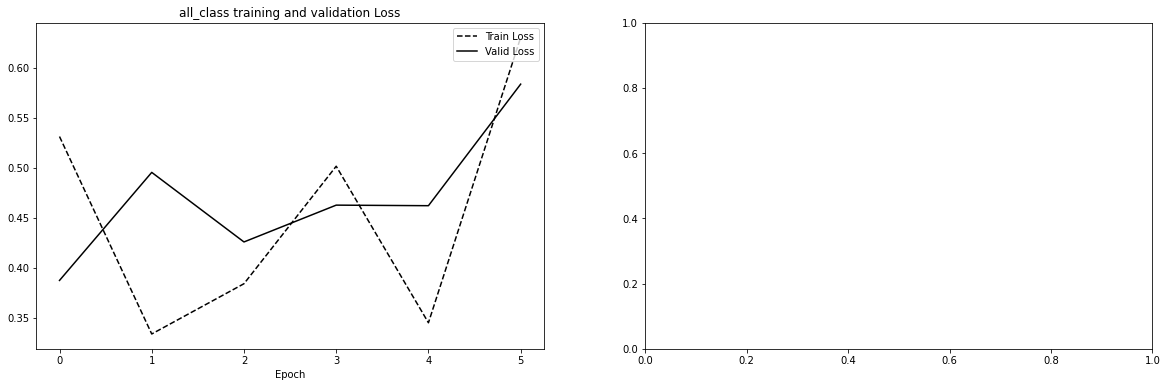

In [29]:
model, history = network_train_generator(model, list_files, regression, classification, augmentation, replace_imgs, batch_size=8, epochs=6)
network_stats(history, regression, classification)

### Classic

In [ ]:
orig_img, orig_x, orig_y, _, _ = general_utils.get_dataset_from_pickle(dario_train_path, 24000, dataset_keep_ratio=0.5)
print()

# removebg_path = new_datasets_folder + 'MASKRCNN replace 31860 samples (start24000, skip12 = 2655) with 20 backgrounds - total 53100/20201020_091307_maskrcnn_replacebg_df53100_1of1.pickle'
# removebg_img, removebg_x, removebg_y, _, _ = general_utils.get_dataset_from_pickle(removebg_path, dataset_keep_ratio=1)

Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-datasets/_originals/dario/v1_train.pickle
dataset original shape: (63726, 3)
dataset keep shape: 	(254, 3)
img_data shape: 	(254,)
x_data shape: 		(254, 60, 108, 3)
y_data shape: 		(254, 4)
odom_dataset shape: 	(254, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (254,)
y_data_for_network single classification variable (4:8) 	 (254, 3)



Epoch 1/2
3/3 - 1s - loss: 0.0423 - x_pred_loss: 0.0094 - y_pred_loss: 0.0095 - z_pred_loss: 0.0048 - yaw_pred_loss: 0.0187 - x_pred_mse: 1.9558e-04 - y_pred_mse: 1.8506e-04 - z_pred_mse: 5.1409e-05 - yaw_pred_mse: 8.7845e-04 - val_loss: 0.0444 - val_x_pred_loss: 0.0112 - val_y_pred_loss: 0.0097 - val_z_pred_loss: 0.0052 - val_yaw_pred_loss: 0.0184 - val_x_pred_mse: 4.4478e-04 - val_y_pred_mse: 2.3273e-04 - val_z_pred_mse: 6.8670e-05 - val_yaw_pred_mse: 7.7464e-04
Epoch 2/2
3/3 - 1s - loss: 0.0423 - x_pred_loss: 0.0094 - y_pred_loss: 0.0095 - z_pred_loss: 0.0048 - yaw_pred_loss: 0.0187 - x_pred_mse: 1.9558e-04 - y_pred_mse: 1.8506e-04 - z_pred_mse: 5.1409e-05 - yaw_pred_mse: 8.7845e-04 - val_loss: 0.0444 - val_x_pred_loss: 0.0112 - val_y_pred_loss: 0.0097 - val_z_pred_loss: 0.0052 - val_yaw_pred_loss: 0.0184 - val_x_pred_mse: 4.4478e-04 - val_y_pred_mse: 2.3273e-04 - val_z_pred_mse: 6.8670e-05 - val_yaw_pred_mse: 7.7464e-04


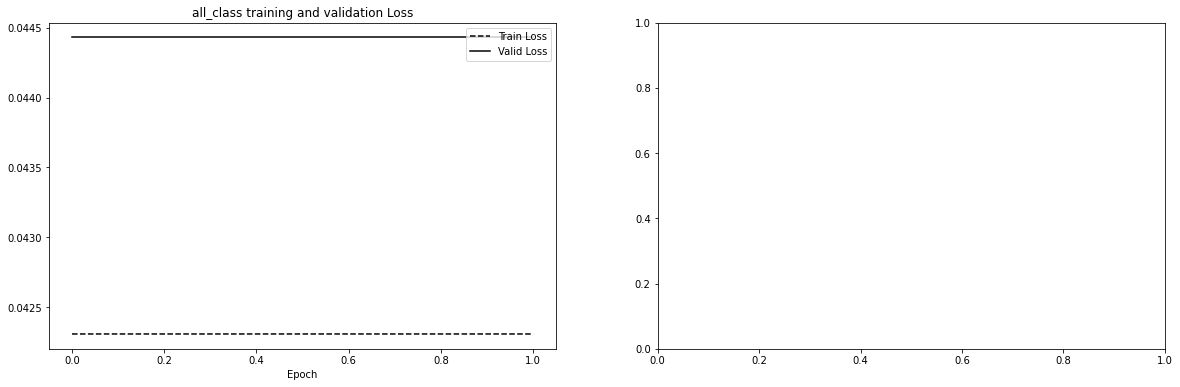

22951

In [ ]:
regression, classification = True, False 
retrain_from_layer = None


vars_interval = slice(0,8) if regression and classification else (slice(0,4) if regression else slice(4,8))
train_x = orig_x
train_y = orig_y[vars_interval]

input_size = train_x[0].shape
model = network_create(dario_model_path, input_size, regression, classification, retrain_from_layer, view_summary=False)
model, history = network_train(model, train_x, train_y, regression, classification, epochs=2)
network_stats(history, regression, classification)

gc.collect()

In [ ]:
export_folder = new_models_folder + 'prova/'
model_name = 'regression on dario original'
keras_utils.network_save(model, export_folder, model_name, None, save_plot = False)

Model saved in /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-models/prova/regression on dario original - v1_all_class_model.h5


'/content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-models/prova/regression on dario original - v1_all_class_model.h5'

## Test

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

if regression:
  dario_path = dario_test_path
  bg20_path = new_datasets_folder + 'MASKRCNN replace 11030 samples TEST (start0, skip10 = 1103) with 20 backgrounds - total 22060/20201022_133340_maskrcnn_replacebg_df22060_1of1.pickle'
  singlebg_room11_path = new_datasets_folder + 'MASKRCNN replace 11030 samples TEST (skip2) with single_room11 background - total 5515/20201022_131619_maskrcnn_replacebg_df5515_1of1.pickle'
  singlebg_room15_path = new_datasets_folder + 'MASKRCNN replace 11030 samples TEST (skip2) with single_room15 background - total 5515/20201022_131716_maskrcnn_replacebg_df5515_1of1.pickle'
  singlebg_room20_path = new_datasets_folder + 'MASKRCNN replace 11030 samples TEST (skip2) with single_room20 background - total 5515/20201022_131733_maskrcnn_replacebg_df5515_1of1.pickle'

  models_path = ['prova/regression on dario original - v1_all_class_model.h5', 'prova/regression on bg20 retrain24 - v1_all_class_model.h5']
  datasets_path = [dario_path, bg20_path, singlebg_room11_path, singlebg_room15_path, singlebg_room20_path]

  for mp in models_path:
    print('\n\n------------------------------------------------------------------------------------------------\n')
    model = tf.keras.models.load_model(new_models_folder + mp)
    print('Model imported from', new_models_folder + mp, '\n\n')

    for dp in datasets_path:
      test_img, test_x, test_y, _, _ = general_utils.get_dataset_from_pickle(dp, dataset_keep_ratio=1)
      print()
 
      pred = model.predict(test_x)
      for vi in range(4):
        y_true = test_y[vi]
        y_pred = pred[vi]
        print(general_utils.variables_names[vi], 'rmse\t', np.math.sqrt(mean_squared_error(y_true, y_pred)))
        print(general_utils.variables_names[vi], 'r2\t', r2_score(y_true, y_pred))
        print()

      evaluate_metrics = model.evaluate(test_x, test_y[vars_interval], batch_size=64, return_dict=True)
      print('\n', evaluate_metrics, '\n', '\n')




------------------------------------------------

Model imported from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-models/prova/regression on dario original - v1_all_class_model.h5 


Reading dataset from /content/drive/My Drive/_ USI/_ THESIS/_ Source code/cnn-drone-befree/src/./../dev-datasets/_originals/dario/v1_test.pickle
dataset original shape: (11035, 3)
dataset keep shape: 	(11035, 3)
img_data shape: 	(11035,)
x_data shape: 		(11035, 60, 108, 3)
y_data shape: 		(11035, 4)
odom_dataset shape: 	(11035, 2)
y_data_for_network shape cannot be computed because elements in the list have different shapes:
y_data_for_network number of variables 				 8
y_data_for_network single regression variable (0:4) 		 (11035,)
y_data_for_network single classification variable (4:8) 	 (11035, 3)

x_pred rmse	 0.10800385995681351
x_pred r2	 0.8323426858915761

y_pred rmse	 0.10351965193853203
y_pred r2	 0.8651102253847072

z_pred rmse	 0.05054580819900306
z_pred